In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [ ]:
def runge_kutta_step(psi, dt, n, m, c, cNN_mag, phi, M1, M2, chunk, g, nonlinear_sites):
    def H_total(psi):
        return haldane_zigzag(n, m, c, cNN_mag, phi, M1, M2, chunk, psi=psi, g=g, nonlinear_sites=nonlinear_sites)

    k1 = -1j * H_total(psi) @ psi
    k2 = -1j * H_total(psi + 0.5 * dt * k1) @ (psi + 0.5 * dt * k1)
    k3 = -1j * H_total(psi + 0.5 * dt * k2) @ (psi + 0.5 * dt * k2)
    k4 = -1j * H_total(psi + dt * k3) @ (psi + dt * k3)

    return psi + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)


In [ ]:
# def generate_zigzag_coords(n, m):
#     """
#     Returns X, Y coordinate arrays for zigzag nanoribbon sites (interleaved A and B).
#     A-sites at even indices, B-sites at odd indices.
#     """
#     # Lattice vectors
#     a1 = np.array([1.5,  np.sqrt(3)/2])
#     a2 = np.array([1.5, -np.sqrt(3)/2])
#     delta = np.array([[0, 0], [1, 0]])  # A and B sublattice offsets

#     # Generate grid of unit cells
#     IX, IY = np.meshgrid(np.arange(n), np.arange(m))
#     IX = IX.flatten()
#     IY = IY.flatten()
#     N_uc = len(IX)
#     N = 2 * N_uc

#     # Allocate coordinate arrays
#     X = np.zeros(N)
#     Y = np.zeros(N)

#     # A sublattice positions
#     A_x = IX * a1[0] + IY * a2[0] + delta[0, 0]
#     A_y = IX * a1[1] + IY * a2[1] + delta[0, 1]

#     # B sublattice positions
#     B_x = IX * a1[0] + IY * a2[0] + delta[1, 0]
#     B_y = IX * a1[1] + IY * a2[1] + delta[1, 1]

#     # Interleave A and B into single arrays
#     X[0::2] = A_x
#     Y[0::2] = A_y
#     X[1::2] = B_x
#     Y[1::2] = B_y

#     return X, Y

# #--------------------------------------------------#

def haldane_zigzag(n, m, c, cNN_mag, phi, M1, M2, chunk, g, psi=None, nonlinear_sites=None):
    """
    Generate the Haldane tight-binding Hamiltonian on a zigzag nanoribbon,
    with optional Kerr nonlinearity from psi if provided.
    """
    N = 2 * n * m
    H = np.zeros((N, N), dtype=complex)
    cNN = cNN_mag * np.exp(1j * phi)

    def index(ix, iy, s):
        """Map (ix, iy, sublattice) to global site index"""
        return 2 * (iy * n + ix) + s

    for ix in range(n):
        for iy in range(m):
            a = index(ix, iy, 0)  # A site
            b = index(ix, iy, 1)  # B site

            # On-site mass terms
            H[a, a] = + g * np.abs(psi[a])**2
            H[b, b] = - g * np.abs(psi[b])**2

            if (n//2 - chunk <= ix <= n//2 + chunk) and (m//2 - chunk <= iy <= m//2 + chunk):
                H[a, a] =  M1 / 2  # M2 / 2
                H[b, b] = - M1 / 2  #  M2 / 2

            # Nearest-neighbor hopping (A-B)
            if ix + 1 < n:
                a1 = index(ix + 1, iy, 0)
                H[b, a1] = -c
            if iy + 1 < m:
                a2 = index(ix, iy + 1, 0)
                H[b, a2] = -c
            H[a, b] = -c

            # Next-nearest-neighbor hopping (A-A and B-B)
            a_nn_offsets = [(1, 0), (-1, 1), (0, -1)]
            for dx, dy in a_nn_offsets:
                ni, nj = ix + dx, iy + dy
                if 0 <= ni < n and 0 <= nj < m:
                    a2 = index(ni, nj, 0)
                    H[a, a2] = -cNN

            b_nn_offsets = [(-1, 0), (1, -1), (0, 1)]
            for dx, dy in b_nn_offsets:
                ni, nj = ix + dx, iy + dy
                if 0 <= ni < n and 0 <= nj < m:
                    b2 = index(ni, nj, 1)
                    H[b, b2] = -cNN

    # Hermitian symmetrization
    H = H + H.conj().T

    # Add Kerr nonlinearity if psi and nonlinear_sites are provided
    # if psi is not None and nonlinear_sites is not None:
    #     for site in nonlinear_sites:
    #       if site in nonlinear_sites_A:
    #         H[site, site] = -g * np.abs(psi[site])**2
    #       elif site in nonlinear_sites_B:
    #         H[site, site] = g * np.abs(psi[site])**2

    return H


def generate_zigzag_coords(n, m):
    """
    Returns X, Y coordinate arrays for zigzag nanoribbon sites (interleaved A and B).
    A-sites at even indices, B-sites at odd indices.
    """
    # Lattice vectors
    a1 = np.array([1.5,  np.sqrt(3)/2])
    a2 = np.array([1.5, -np.sqrt(3)/2])
    delta = np.array([[0, 0], [1, 0]])  # A and B sublattice offsets

    # Generate grid of unit cells
    IX, IY = np.meshgrid(np.arange(n), np.arange(m))
    IX = IX.flatten()
    IY = IY.flatten()
    N_uc = len(IX)
    N = 2 * N_uc

    # Allocate coordinate arrays
    X = np.zeros(N)
    Y = np.zeros(N)

    # A sublattice positions
    A_x = IX * a1[0] + IY * a2[0] + delta[0, 0]
    A_y = IX * a1[1] + IY * a2[1] + delta[0, 1]

    # B sublattice positions
    B_x = IX * a1[0] + IY * a2[0] + delta[1, 0]
    B_y = IX * a1[1] + IY * a2[1] + delta[1, 1]

    # Interleave A and B into single arrays
    X[0::2] = A_x
    Y[0::2] = A_y
    X[1::2] = B_x
    Y[1::2] = B_y

    return X, Y

#--------------------------------------------------#

# def haldane_zigzag(n, m, c, cNN_mag, phi, M1, M2, chunk, g, psi=None, nonlinear_sites=None):
#     """
#     Generate the Haldane tight-binding Hamiltonian on a zigzag nanoribbon,
#     with optional Kerr nonlinearity from psi if provided.
#     """
#     N = 2 * n * m
#     H = np.zeros((N, N), dtype=complex)
#     cNN = cNN_mag * np.exp(1j * phi)

#     def index(ix, iy, s):
#         """Map (ix, iy, sublattice) to global site index"""
#         return 2 * (iy * n + ix) + s

#     for ix in range(n):
#         for iy in range(m):
#             a = index(ix, iy, 0)  # A site
#             b = index(ix, iy, 1)  # B site

#             # On-site mass terms
#             H[a, a] = M1 / 2
#             H[b, b] = - M1 / 2

#             if (n//2 - chunk <= ix <= n//2 + chunk) and (m//2 - chunk <= iy <= m//2 + chunk):
#                 H[a, a] =   g * np.abs(psi[a])**2 # M2 / 2
#                 H[b, b] =   -g * np.abs(psi[b])**2 # M2 / 2

#             # Nearest-neighbor hopping (A-B)
#             if ix + 1 < n:
#                 a1 = index(ix + 1, iy, 0)
#                 H[b, a1] = -c
#             if iy + 1 < m:
#                 a2 = index(ix, iy + 1, 0)
#                 H[b, a2] = -c
#             H[a, b] = -c

#             # Next-nearest-neighbor hopping (A-A and B-B)
#             a_nn_offsets = [(1, 0), (-1, 1), (0, -1)]
#             for dx, dy in a_nn_offsets:
#                 ni, nj = ix + dx, iy + dy
#                 if 0 <= ni < n and 0 <= nj < m:
#                     a2 = index(ni, nj, 0)
#                     H[a, a2] = -cNN

#             b_nn_offsets = [(-1, 0), (1, -1), (0, 1)]
#             for dx, dy in b_nn_offsets:
#                 ni, nj = ix + dx, iy + dy
#                 if 0 <= ni < n and 0 <= nj < m:
#                     b2 = index(ni, nj, 1)
#                     H[b, b2] = -cNN

#     # Hermitian symmetrization
#     H = H + H.conj().T

#     # Add Kerr nonlinearity if psi and nonlinear_sites are provided
#     # if psi is not None and nonlinear_sites is not None:
#     #     for site in nonlinear_sites:
#     #       if site in nonlinear_sites_A:
#     #         H[site, site] = -g * np.abs(psi[site])**2
#     #       elif site in nonlinear_sites_B:
#     #         H[site, site] = g * np.abs(psi[site])**2

#     return H


In [ ]:
# Parameters
n, m = 20, 20        # lattice dimensions
c = 1.0              # NN hopping
cNN_mag = 0.1 * c    # NNN hopping magnitude
phi = np.pi / 2      # NNN hopping phase
M1 = 0.1               # bulk mass
M2 = 0.1               # perturbed region mass
chunk = 5            # perturbation chunk size
g = 10                # Kerr strength
# Create Hamiltonian


N = 2 * n * m
psi = np.zeros(N, dtype=complex)

# For example, initialize with a localized state on a few B-sites
# B-site index = 2*(iy * n + ix) + 1
ix, iy = 10, 5

# psi[139] = np.sqrt(10/6)*np.exp(1j*np.pi/6) #1
# psi[140] = np.sqrt(10/6)*np.exp(2j*np.pi/6) #2
# psi[141] = np.sqrt(10/6)*np.exp(3j*np.pi/6) #3
# psi[178] = np.sqrt(10/6)*np.exp(4j*np.pi/6) #4
# psi[179] = np.sqrt(10/6)*np.exp(5j*np.pi/6) #5
# psi[180] = np.sqrt(10/6)*np.exp(6j*np.pi/6) #6

mag = 3

psi[210] = mag
psi[212] = -mag   # for non trivial inner chunk
psi[214] = mag
psi[216] = -mag
psi[218] = mag

# psi[171] = mag
# psi[173] = -mag
# psi[175] = mag     # for trivial inner chunk
# psi[177] = -mag
# psi[179] = mag

# psi[25] = 6
# psi[27] = -6
# psi[29] = 6
# psi[31] = -6



# psi = eigenvectors[:, 400]

H = haldane_zigzag(n, m, c, cNN_mag, phi, M1, M2, chunk, g=g, psi=psi)


#........................

nonlinear_sites = [139, 140, 141, 178, 179, 180]  # Your six sites
nonlinear_sites_A = [139, 141, 179]
nonlinear_sites_B = [140, 178, 180]
timesteps = 1000  # maybe run more steps for a smooth plot
dt = 0.01

evolution = []
site_intensities = {site: [] for site in nonlinear_sites}

for _ in range(timesteps):
    psi = runge_kutta_step(psi, dt, n, m, c, cNN_mag, phi, M1, M2, chunk, g, nonlinear_sites)
    evolution.append(np.abs(psi)**2)





In [ ]:
import numpy as np
from datetime import datetime

# Convert list → array for saving
evolution = np.asarray(evolution, dtype=float)  # shape (timesteps, N)

# Choose filename based on mag
filename = f"evolution_non_trivial_mag{mag}_12000.npz"

# Save relevant data
np.savez_compressed(
    filename,
    evolution=evolution,          # (timesteps, N)
    timesteps=timesteps,
    dt=dt,
    mag=mag,
    g=g,
    n=n, m=m,
    c=c,
    cNN_mag=cNN_mag,
    phi=phi,
    M1=M1,
    M2=M2,
    chunk=chunk,
    nonlinear_sites=np.array(nonlinear_sites),
    nonlinear_sites_A=np.array(nonlinear_sites_A),
    nonlinear_sites_B=np.array(nonlinear_sites_B),
    created_utc=str(datetime.utcnow().isoformat()) + "Z",
)

print(f"Saved evolution for mag={mag} to {filename}")


/tmp/ipython-input-2549028527.py:28: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  created_utc=str(datetime.utcnow().isoformat()) + "Z",


Saved evolution for mag=3 to evolution_non_trivial_mag3_12000.npz


In [ ]:
data = np.load("evolution_non_trivial_mag3.npz", allow_pickle=True)
evolution = data["evolution"]    # (timesteps, N)
mag       = data["mag"].item()   # scalar
timesteps = data["timesteps"].item()
timesteps

6000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter

# --- pack evolution into an array (T, N) ---
evolution = np.asarray(evolution, dtype=float)  # list -> array
T = evolution.shape[0]
x = np.arange(T)  # or physical time: x = np.arange(T) * dt

# --- compute top-6 sum per frame (fast) ---
k = 6
# argpartition avoids full sort across all N each frame
# Take the largest k entries along axis=1, then sum
top6_sums = np.partition(evolution, -k, axis=1)[:, -k:].sum(axis=1)

# ---------------- PLOT: absolute (non-normalized) ----------------
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(x, top6_sums, lw=2)

ax.set_xlabel("Time step", fontsize=14)
ax.set_ylabel("Edge-state population (top-6 sum)", fontsize=14)
ax.set_title("Evolution of Edge-State Population (Top-6 Sum)", fontsize=16)

# # (Optional) add a threshold line, e.g. 50
# threshold = 5
# ax.axhline(threshold, color='k', ls='--', lw=1.2, alpha=0.7)
# ax.text(0.01, 0.97, f"Threshold = {threshold}", transform=ax.transAxes,
#         va='top', ha='left', fontsize=12,
#         bbox=dict(boxstyle='round', fc='white', alpha=0.7))

# nice styling
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which="major", linestyle="--", alpha=0.35)
ax.grid(which="minor", linestyle=":", alpha=0.2)
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", width=1.2)
ax.tick_params(axis="both", which="major", length=6)
ax.tick_params(axis="both", which="minor", length=3)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.show()

# -------------- (Optional) PLOT: normalized curve --------------
def normalize_series(y, method="max"):
    y = np.asarray(y, float)
    if method == "max":
        scale = np.max(y)
    elif method == "t0":
        scale = y[0]
    else:
        raise ValueError("method must be 'max' or 't0'")
    if scale <= 0 or not np.isfinite(scale):
        return np.zeros_like(y), 1.0
    return y/scale, scale

y_norm, _ = normalize_series(top6_sums, method="max")

fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(x, y_norm, lw=2)

ax.set_xlabel("Time step", fontsize=14)
ax.set_ylabel("Normalized edge-state population", fontsize=14)
ax.set_title("Normalized Evolution of Edge-State Population (Top-6 Sum)", fontsize=16)

# (Optional) 50% line
ax.axhline(0.5, color='k', ls='--', lw=1.2, alpha=0.7)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which="major", linestyle="--", alpha=0.35)
ax.grid(which="minor", linestyle=":", alpha=0.2)
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", width=1.2)
ax.tick_params(axis="both", which="major", length=6)
ax.tick_params(axis="both", which="minor", length=3)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.show()


In [ ]:
# --- IPR for the in-memory run you just simulated ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter

# pack to array
evolution = np.asarray(evolution, dtype=float)  # shape (T, N)
T, N = evolution.shape
x = np.arange(T)  # or x = np.arange(T) * dt

# --- IPR helpers ---
def ipr_timeseries(intensity_TN):
    """Global IPR(t) = sum p^2 / (sum p)^2, frame by frame."""
    num = (intensity_TN**2).sum(axis=1)
    den = (intensity_TN.sum(axis=1))**2 + 1e-16
    return num / den

def ipr_timeseries_mask(intensity_TN, mask):
    """Subset IPR over a boolean mask (e.g., edge sites)."""
    sub = intensity_TN[:, mask]
    num = (sub**2).sum(axis=1)
    den = (sub.sum(axis=1))**2
    return np.where(den > 1e-30, num / (den + 1e-16), np.nan)

# --- compute IPRs ---
ipr_global = ipr_timeseries(evolution)

# optional: IPR on your six nonlinear sites (edge proxy)
edge_mask = np.zeros(N, dtype=bool)
edge_mask[np.array(nonlinear_sites, dtype=int)] = True
ipr_edge = ipr_timeseries_mask(evolution, edge_mask)

# legend info for THIS run
mag_here = mag  # you set mag = 3 above; change if different
nl_term_here = g * 5 * (mag_here**2)  # g * sum_{j=1..5} |psi_j(0)|^2

# --- Plot: Global IPR vs time ---
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(x, ipr_global, lw=2,
        label=rf"Global IPR  ($|\psi_i(0)|={mag_here},\; g\sum_{{j=1}}^5|\psi_j(0)|^2={nl_term_here}$)")

ax.set_xlabel("Time step")
ax.set_ylabel("IPR (dimensionless)")
ax.set_title("Inverse Participation Ratio (Global)")
ax.set_ylim([0,0.01])
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which="major", linestyle="--", alpha=0.35)
ax.grid(which="minor", linestyle=":", alpha=0.2)
for s in ("top", "right"):
    ax.spines[s].set_visible(False)
ax.tick_params(axis="both", which="both", width=1.2)
ax.tick_params(axis="both", which="major", length=6)
ax.tick_params(axis="both", which="minor", length=3)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.legend(frameon=False, fontsize=11)
plt.show()



In [ ]:
#........................
X, Y = generate_zigzag_coords(n, m)
plt.rcParams['animation.embed_limit'] = 500  # Sets the limit to 50 MB


def update(frame):
    prob_density = evolution[frame]
    scat.set_array(prob_density)
    ax.set_title(f"Time Step: {frame}", fontsize=20)
    return scat,

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))
# Provide initial color data (e.g., first frame)
initial_data = evolution[0]
scat = ax.scatter(X, Y, c=initial_data, cmap='viridis', s=90, vmin=0, vmax=mag)

# Create a divider and append a smaller colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cbar = plt.colorbar(scat, cax=cax)
cbar.set_label('Probability Density', fontsize=16)  # Increase colorbar label font size
cbar.ax.tick_params(labelsize=14)  # Increase tick labels on the colorbar

ax.set_xlabel("x (a.u.)", fontsize=18)  # Increase x-axis label font size
ax.set_ylabel("y (a.u.)", fontsize=18)  # Increase y-axis label font size
ax.tick_params(axis='both', labelsize=16)  # Increase tick labels on both axes
ax.set_aspect('equal', adjustable='box')


def update(frame):
    prob_density = evolution[frame]
    scat.set_array(prob_density)
    ax.set_title(f"Time Step: {frame}", fontsize=20)
    return scat,

ani = FuncAnimation(fig, update, frames=range(0, timesteps, 100), blit=True)
plt.close(fig)

from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
### multiple runs for diff mag:

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter
from datetime import datetime

# ------------------ Global / model parameters (from your setup) ------------------
n, m = 20, 20        # lattice dimensions
c = 1.0              # NN hopping
cNN_mag = 0.1 * c    # NNN hopping magnitude
phi = np.pi / 2      # NNN hopping phase
M1 = 0.1             # bulk mass
M2 = 0.1             # perturbed region mass
chunk = 5            # perturbation chunk size
g = 10               # Kerr strength

# Nonlinear / tracked sites (unused below but kept for your RK step signature)
nonlinear_sites     = [139, 140, 141, 178, 179, 180]
nonlinear_sites_A   = [139, 141, 179]
nonlinear_sites_B   = [140, 178, 180]

# Time integration
timesteps = 20000
dt = 0.01

# Initial state indices you used in the example
# init_indices = [171, 173, 175, 177, 179] # for trivial inner chunk
init_indices = [210, 212, 214, 216, 218] # for non trivial inner chunk

# Magnitudes to scan
mag_values = [1,np.sqrt(2),np.sqrt(3),2,3,4,5,6]   # <- edit if desired

# ------------------ Plot styling (your recommended style) ------------------
mpl.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 12,
    "font.family": "serif",
    "axes.titleweight": "bold",
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.linewidth": 1.2,
})

# ------------------ Helpers ------------------
def initialize_state(N, magnitude, indices):
    """Create psi with given magnitude on specified indices (alternating signs)."""
    psi0 = np.zeros(N, dtype=complex)
    for k, idx in enumerate(indices):
        psi0[idx] = magnitude if (k % 2 == 0) else -magnitude
    return psi0

def normalize_series(y, method="max"):
    """Return y_norm and the scale used. method in {'max','t0','first_nonzero'}."""
    y = np.asarray(y, dtype=float)
    if method == "max":
        scale = np.max(y)
    elif method == "t0":
        scale = y[0]
    elif method == "first_nonzero":
        nz = np.nonzero(y)[0]
        scale = y[nz[0]] if nz.size else 0.0
    else:
        raise ValueError("method must be 'max', 't0', or 'first_nonzero'")
    if scale <= 0 or not np.isfinite(scale):
        return np.zeros_like(y), 1.0
    return y / scale, scale

def half_life_index(y_norm):
    """First index where y_norm <= 0.5; None if never crosses."""
    idx = np.where(y_norm <= 0.5)[0]
    return int(idx[0]) if idx.size else None

def ipr_timeseries(evolution):
    """
    Optional: scale-invariant IPR per frame.
    evolution: (T, N) array of |psi|^2
    """
    num = (evolution**2).sum(axis=1)
    den = (evolution.sum(axis=1))**2 + 1e-16
    return num / den

def run_one_simulation(magnitude):
    """
    Build Hamiltonian dependent on the initial psi (for Kerr term), run RK evolution,
    and return: evolution (T x N), top-6 sums over time.
    """
    N = 2 * n * m
    psi = initialize_state(N, magnitude, init_indices)

    # Build initial Hamiltonian (if haldane_zigzag depends on psi for Kerr)
    H = haldane_zigzag(n, m, c, cNN_mag, phi, M1, M2, chunk, g=g, psi=psi)

    # Evolve
    evolution = np.empty((timesteps, N), dtype=float)
    for t in range(timesteps):
        # store |psi|^2
        evolution[t] = np.abs(psi)**2
        # advance
        psi = runge_kutta_step(psi, dt, n, m, c, cNN_mag, phi, M1, M2, chunk, g, nonlinear_sites)

    # --- Top-6 sum per frame (your metric) ---
    top6_sums = np.sort(evolution, axis=1)[:, -6:].sum(axis=1)

    return evolution, top6_sums

def save_run(filename, evolution, top6_sums, magnitude):
    np.savez_compressed(
        filename,
        evolution=evolution,              # shape: (timesteps, N)
        top6_sums=top6_sums,             # shape: (timesteps,)
        top15_sums=top6_sums,            # kept for compatibility with your plotting snippet
        timesteps=timesteps,
        dt=dt,
        mag=magnitude,
        n=n, m=m, c=c, cNN_mag=cNN_mag, phi=phi, M1=M1, M2=M2, chunk=chunk, g=g,
        init_indices=np.array(init_indices),
        nonlinear_sites=np.array(nonlinear_sites),
        created_utc=str(datetime.utcnow().isoformat()) + "Z",
    )

# ------------------ Run scans and collect results ------------------
results = {}  # mag -> {"evolution", "top6_sums", "top15_sums", "ipr" (optional)}

for mag in mag_values:
    print(f"Running simulation for mag = {mag} ...")
    evolution, top6_sums = run_one_simulation(mag)
    results[mag] = {
        "evolution": evolution,
        "top6_sums": top6_sums,
        "top15_sums": top6_sums,  # alias for your existing plotting code
    }
    # Optional: compute IPR for later comparison
    # results[mag]["ipr"] = ipr_timeseries(evolution)

    # Save each run
    out_name = f"evolution_non_trivial_mag{mag}.npz"
    save_run(out_name, evolution, top6_sums, mag)
    print(f"  saved -> {out_name}")

print("All simulations complete.")

# # ================== PLOTTING: Normalized top-6 curves ==================
# NORM_METHOD = "max"  # {'max','t0','first_nonzero'}

# # ---- Linear y (normalized) ----
# fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# x = np.arange(timesteps)  # or physical time: x = np.arange(timesteps) * dt

# half_lives = {}  # magnitude -> {'idx', 'time'}

# for mag in mag_values:
#     y = results[mag]["top15_sums"]  # using your key
#     y_norm, scale = normalize_series(y, method=NORM_METHOD)
#     ax.plot(x, y_norm, lw=2, label=fr"$|\psi_i(0)|={mag}$")
#     # optional half-life mark
#     hidx = half_life_index(y_norm)
#     if hidx is not None:
#         half_lives[mag] = {"idx": hidx, "time": hidx * dt}

# ax.set_xlabel("Time step")
# ax.set_ylabel("Normalized edge-state population")
# ax.set_title("Normalized Evolution of Edge-State Population vs. Initial Amplitude")

# ax.xaxis.set_minor_locator(AutoMinorLocator())
# ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.grid(which="major", linestyle="--", alpha=0.35)
# ax.grid(which="minor", linestyle=":", alpha=0.2)
# for spine in ("top", "right"):
#     ax.spines[spine].set_visible(False)
# ax.tick_params(axis="both", which="both", width=1.2)
# ax.tick_params(axis="both", which="major", length=6)
# ax.tick_params(axis="both", which="minor", length=3)
# ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# ax.legend(frameon=False, fontsize=12)

# plt.savefig("edge_state_multi_normalized.pdf", bbox_inches="tight")
# plt.savefig("edge_state_multi_normalized.png", bbox_inches="tight")
# plt.show()

# # (Optional) print half-lives
# for mag, hl in half_lives.items():
#     print(f"mag={mag}: half-life ~ {hl['idx']} steps ({hl['time']:.3f} time units)")

# # ---- Semilog-y (normalized) for clearer decay comparison ----
# fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
# for mag in mag_values:
#     y = results[mag]["top15_sums"]
#     y_norm, _ = normalize_series(y, method=NORM_METHOD)
#     ax.semilogy(x, np.clip(y_norm, 1e-12, None), lw=2, label=fr"$|\psi_i(0)|={mag}$")

# ax.set_xlabel("Time step")
# ax.set_ylabel("Normalized edge-state population (semilog)")
# ax.set_title("Decay comparison (semilog-y)")

# ax.xaxis.set_minor_locator(AutoMinorLocator())
# ax.grid(which="major", linestyle="--", alpha=0.35)
# for spine in ("top", "right"):
#     ax.spines[spine].set_visible(False)
# ax.tick_params(axis="both", which="major", length=6, width=1.2)
# ax.legend(frameon=False, fontsize=12)

# plt.savefig("edge_state_multi_normalized_semilog.pdf", bbox_inches="tight")
# plt.show()


Running simulation for mag = 1 ...


/tmp/ipython-input-574284467.py:123: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  created_utc=str(datetime.utcnow().isoformat()) + "Z",


  saved -> evolution_non_trivial_mag1.npz
Running simulation for mag = 1.4142135623730951 ...
  saved -> evolution_non_trivial_mag1.4142135623730951.npz
Running simulation for mag = 1.7320508075688772 ...
  saved -> evolution_non_trivial_mag1.7320508075688772.npz
Running simulation for mag = 2 ...
  saved -> evolution_non_trivial_mag2.npz
Running simulation for mag = 3 ...
  saved -> evolution_non_trivial_mag3.npz
Running simulation for mag = 4 ...
  saved -> evolution_non_trivial_mag4.npz
Running simulation for mag = 5 ...


KeyboardInterrupt: 

In [ ]:

# ------------------ Plot all curves on one figure ------------------
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

x = np.arange(timesteps)  # if you prefer physical time, use x = np.arange(timesteps) * dt

for mag in mag_values:
    ax.plot(x, results[mag]["top15_sums"], lw=2, label=f"|ψ_i(0)| = {mag}")

ax.set_xlabel("Time step")
ax.set_ylabel("Edge state population ")
ax.set_title("Evolution of Edge-State Population vs. Initial Amplitude")

# Optional axis limits (you can auto-scale by commenting next line)
# ax.set_ylim(0, 5.1)

# Minor ticks + grid
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which="major", linestyle="--", alpha=0.35)
ax.grid(which="minor", linestyle=":", alpha=0.2)

# Cleaner spines & thicker ticks
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", width=1.2)
ax.tick_params(axis="both", which="major", length=6)
ax.tick_params(axis="both", which="minor", length=3)

# Nice numeric formatting
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

ax.legend(frameon=False, fontsize=12)

plt.savefig("edge_state_multi.pdf", bbox_inches="tight")
plt.savefig("edge_state_multi.png", bbox_inches="tight")
plt.show()


# IPR

In [ ]:
### multiple runs for diff mag:

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter
from datetime import datetime

# ------------------ Global / model parameters (from your setup) ------------------
n, m = 20, 20        # lattice dimensions
c = 1.0              # NN hopping
cNN_mag = 0.1 * c    # NNN hopping magnitude
phi = np.pi / 2      # NNN hopping phase
M1 = 0.1             # bulk mass
M2 = 0.1             # perturbed region mass
chunk = 5            # perturbation chunk size
g = 10               # Kerr strength

# Nonlinear / tracked sites you used
nonlinear_sites     = [139, 140, 141, 178, 179, 180]
nonlinear_sites_A   = [139, 141, 179]
nonlinear_sites_B   = [140, 178, 180]

# Time integration
timesteps = 20000
dt = 0.01

# Initial state indices you used in the example
init_indices = [171, 173, 175, 177, 179]

# Magnitudes to scan (choose any 5 you like)
mag_values = [1, 2, 3, 4, 5, 6]   # <- edit if desired

# ------------------ Plot styling (your recommended style) ------------------
mpl.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 12,
    "font.family": "serif",
    "axes.titleweight": "bold",
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.linewidth": 1.2,
})

# ------------------ Lattice coordinates (needed for cross metric) ------------------
# Assumes your generator exists and returns arrays of length N=2*n*m
X, Y = generate_zigzag_coords(n, m)   # shape (N,)

# ------------------ Helpers ------------------
def initialize_state(N, magnitude, indices):
    """Create psi with given magnitude on specified indices (alternating signs as in your snippet)."""
    psi0 = np.zeros(N, dtype=complex)
    for k, idx in enumerate(indices):
        psi0[idx] = magnitude if (k % 2 == 0) else -magnitude
    return psi0

# ---- Direction-aware 5-site cross helpers ----
def _typical_spacing(vals, round_dec=6):
    u = np.unique(np.round(vals, round_dec))
    if len(u) < 2:
        return 1.0
    diffs = np.diff(np.sort(u))
    diffs = diffs[diffs > 0]
    return float(np.median(diffs)) if len(diffs) else 1.0

def _infer_motion(prev_idx, curr_idx, X, Y, dx, dy, min_move_frac=0.2):
    """Return 'h' if motion mostly horizontal, else 'v'. If tiny move, keep previous direction."""
    if prev_idx is None:
        return 'h'
    ddx = X[curr_idx] - X[prev_idx]
    ddy = Y[curr_idx] - Y[prev_idx]
    # if movement is tiny, prefer previous orientation (handled by caller)
    if abs(ddx) < min_move_frac*dx and abs(ddy) < min_move_frac*dy:
        return None
    return 'h' if abs(ddx) >= abs(ddy) else 'v'

def _five_cross_indices(center_idx, X, Y, motion, dx, dy, tol_factor=0.6):
    """
    motion='h' -> vertical line: center ±2 in Y
    motion='v' -> horizontal line: center ±2 in X
    Returns up to 5 indices (fewer near corners).
    """
    x0, y0 = X[center_idx], Y[center_idx]
    if motion == 'h':
        # vertical column: |X-x0| small
        col_mask = np.abs(X - x0) <= tol_factor * dx
        cand = np.where(col_mask)[0]
        if cand.size == 0:
            return np.array([center_idx])
        cand = cand[np.argsort(Y[cand])]
        # locate center within column
        pos = np.where(cand == center_idx)[0]
        if pos.size == 0:
            # include center and re-sort
            cand = np.unique(np.concatenate(([center_idx], cand)))
            cand = cand[np.argsort(Y[cand])]
            pos = np.where(cand == center_idx)[0]
        pos = int(pos[0])
        sel = cand[max(0, pos-2): pos+3]  # center ±2
    else:
        # horizontal row: |Y-y0| small
        row_mask = np.abs(Y - y0) <= tol_factor * dy
        cand = np.where(row_mask)[0]
        if cand.size == 0:
            return np.array([center_idx])
        cand = cand[np.argsort(X[cand])]
        pos = np.where(cand == center_idx)[0]
        if pos.size == 0:
            cand = np.unique(np.concatenate(([center_idx], cand)))
            cand = cand[np.argsort(X[cand])]
            pos = np.where(cand == center_idx)[0]
        pos = int(pos[0])
        sel = cand[max(0, pos-2): pos+3]

    # ensure center included, dedup + cap to 5
    if center_idx not in sel:
        sel = np.insert(sel, 0, center_idx)
    uniq, seen = [], set()
    for i in sel:
        if i not in seen:
            uniq.append(i); seen.add(i)
    return np.array(uniq[:5])

def cross_sum_timeseries(evolution, X, Y, tol_factor=0.6):
    """
    For each frame: brightest site -> infer motion -> take center ±2 orthogonal strip -> sum.
    Returns: cross_sums (T,), cross_indices (T,5) with -1 padding, motion_flags list['h'/'v'].
    """
    T, N = evolution.shape
    dx = _typical_spacing(X); dy = _typical_spacing(Y)

    cross_sums = np.empty(T, dtype=float)
    cross_indices = -np.ones((T, 5), dtype=int)
    motion_flags = []
    prev_idx = None
    prev_motion = 'h'  # default initial orientation

    for t in range(T):
        p = evolution[t]
        idx = int(np.argmax(p))
        motion = _infer_motion(prev_idx, idx, X, Y, dx, dy)
        if motion is None:
            motion = prev_motion  # stabilize when displacement is tiny
        sel = _five_cross_indices(idx, X, Y, motion, dx, dy, tol_factor=tol_factor)
        cross_sums[t] = float(p[sel].sum())
        cross_indices[t, :len(sel)] = sel
        motion_flags.append(motion)
        prev_idx = idx
        prev_motion = motion

    return cross_sums, cross_indices, motion_flags

def run_one_simulation(magnitude):
    """
    Build Hamiltonian dependent on the initial psi (for Kerr term), run RK evolution,
    and return the full evolution (timesteps x N), top-6 sums over time, and cross-sum metric.
    """
    N = 2 * n * m
    psi = initialize_state(N, magnitude, init_indices)

    # Build initial Hamiltonian (if haldane_zigzag depends on psi for Kerr)
    H = haldane_zigzag(n, m, c, cNN_mag, phi, M1, M2, chunk, g=g, psi=psi)

    # Evolve
    evolution = np.empty((timesteps, N), dtype=float)
    for t in range(timesteps):
        evolution[t] = np.abs(psi)**2  # store |psi|^2
        psi = runge_kutta_step(psi, dt, n, m, c, cNN_mag, phi, M1, M2, chunk, g, nonlinear_sites)

    # --- Your existing "top-6" metric (comment said top-15; code uses 6, kept as-is) ---
    top6_sums = np.sort(evolution, axis=1)[:, -6:].sum(axis=1)

    # --- New: direction-aware 5-site cross metric ---
    cross_sums, cross_indices, motion_flags = cross_sum_timeseries(evolution, X, Y, tol_factor=0.6)

    return evolution, top6_sums, cross_sums, cross_indices, motion_flags

def save_run(filename, evolution, top6_sums, cross_sums, magnitude, cross_indices=None, motion_flags=None):
    np.savez_compressed(
        filename,
        evolution=evolution,              # shape: (timesteps, N)
        top6_sums=top6_sums,             # shape: (timesteps,)
        cross_sums=cross_sums,           # shape: (timesteps,)
        cross_indices=(cross_indices if cross_indices is not None else np.array([[]], dtype=int)),
        motion_flags=np.array(motion_flags if motion_flags is not None else []),
        timesteps=timesteps,
        dt=dt,
        mag=magnitude,
        n=n, m=m, c=c, cNN_mag=cNN_mag, phi=phi, M1=M1, M2=M2, chunk=chunk, g=g,
        init_indices=np.array(init_indices),
        nonlinear_sites=np.array(nonlinear_sites),
        created_utc=str(datetime.utcnow().isoformat()) + "Z",
    )

# ------------------ Run scans and collect results ------------------
results = {}  # mag -> {...}

for mag in mag_values:
    print(f"Running simulation for mag = {mag} ...")
    evolution, top6_sums, cross_sums, cross_indices, motion_flags = run_one_simulation(mag)
    results[mag] = {
        "evolution": evolution,
        "top6_sums": top6_sums,
        "cross_sums": cross_sums,
        "cross_indices": cross_indices,
        "motion_flags": motion_flags,
    }

    # Save each run
    out_name = f"evolution_mag{mag}.npz"
    save_run(out_name, evolution, top6_sums, cross_sums, mag, cross_indices, motion_flags)
    print(f"  saved -> {out_name}")

print("All simulations complete.")


Running simulation for mag = 1 ...


/tmp/ipython-input-2236273382.py:195: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  created_utc=str(datetime.utcnow().isoformat()) + "Z",


  saved -> evolution_mag1.npz
Running simulation for mag = 2 ...
  saved -> evolution_mag2.npz
Running simulation for mag = 3 ...
  saved -> evolution_mag3.npz
Running simulation for mag = 4 ...
  saved -> evolution_mag4.npz
Running simulation for mag = 5 ...
  saved -> evolution_mag5.npz
Running simulation for mag = 6 ...
  saved -> evolution_mag6.npz
All simulations complete.


<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\;'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\;'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1273798503.py:20: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x, ipr, lw=2, label=f"$|\psi_i(0)|={mag},\;\; g\sum_{{j=1}}^5|\psi_j(0)|^2={nl_term}$")
/tmp/ipython-input-1273798503.py:20: SyntaxWarning: invalid escape sequence '\;'
  ax.plot(x, ipr, lw=2, label=f"$|\psi_i(0)|={mag},\;\; g\sum_{{j=1}}^5|\psi_j(0)|^2={nl_term}$")
/tmp/ipython-input-1273798503.py:20: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x, ipr, lw=2, label=f"$|\psi_i(0)|={mag},\;\; g\sum_{{j=1}}^5|\psi_j(0)|^2={nl_term}$")


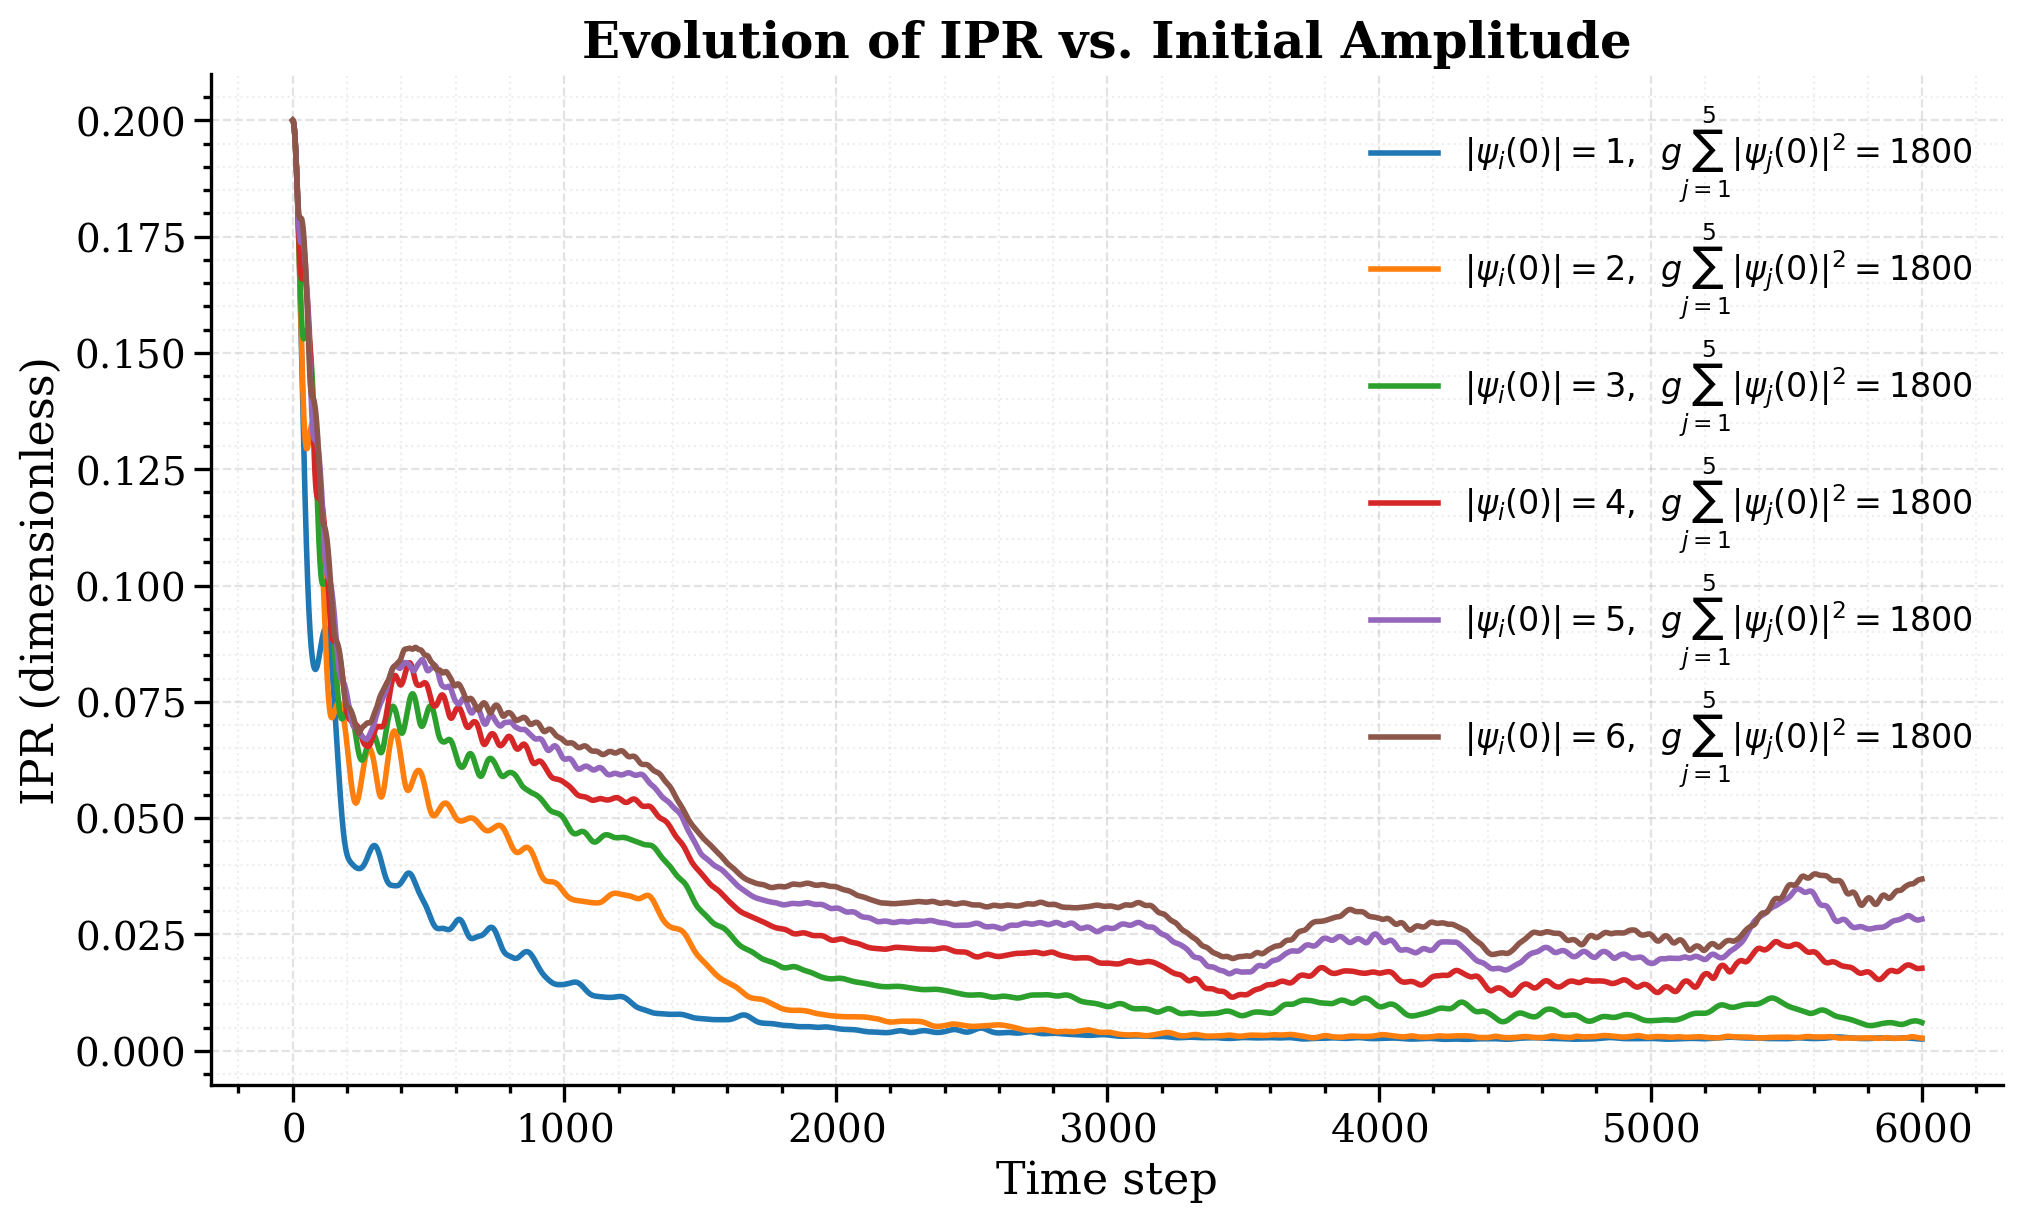

In [ ]:
# -------- IPR helper (scale-invariant; safe if norm drifts) --------
def ipr_timeseries(evolution):
    # evolution: (T, N) array of |psi|^2
    num = (evolution**2).sum(axis=1)
    den = (evolution.sum(axis=1))**2 + 1e-16
    return num / den

# Optionally precompute & store IPR for reuse
for mag in mag_values:
    if "ipr" not in results[mag]:
        results[mag]["ipr"] = ipr_timeseries(results[mag]["evolution"])

# ------------------ Plot all IPR curves on one figure ------------------
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

x = np.arange(timesteps)          # or x = np.arange(timesteps) * dt for physical time

for mag in mag_values:
    ipr = results[mag]["ipr"]     # shape (T,)
    ax.plot(x, ipr, lw=2, label=f"$|\psi_i(0)|={mag},\;\; g\sum_{{j=1}}^5|\psi_j(0)|^2={nl_term}$")

ax.set_xlabel("Time step")
ax.set_ylabel("IPR (dimensionless)")
ax.set_title("Evolution of IPR vs. Initial Amplitude")

# Optional axis limits, e.g., ax.set_ylim(0, 1) if desired
# ax.set_ylim(0, 1)

# Minor ticks + grid
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which="major", linestyle="--", alpha=0.35)
ax.grid(which="minor", linestyle=":", alpha=0.2)

# Cleaner spines & thicker ticks
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", width=1.2)
ax.tick_params(axis="both", which="major", length=6)
ax.tick_params(axis="both", which="minor", length=3)

# Nice numeric formatting
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

ax.legend(frameon=False, fontsize=12)

plt.savefig("ipr_multi.pdf", bbox_inches="tight")
plt.savefig("ipr_multi.png", bbox_inches="tight")
plt.show()


In [ ]:
#........................
evolution=results[6]["evolution"]
#........................
X, Y = generate_zigzag_coords(n, m)
plt.rcParams['animation.embed_limit'] = 500  # Sets the limit to 50 MB


def update(frame):
    prob_density = evolution[frame]
    scat.set_array(prob_density)
    ax.set_title(f"Time Step: {frame}", fontsize=20)
    return scat,

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))
# Provide initial color data (e.g., first frame)
initial_data = evolution[0]
scat = ax.scatter(X, Y, c=initial_data, cmap='viridis', s=90, vmin=0, vmax=2)

# Create a divider and append a smaller colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cbar = plt.colorbar(scat, cax=cax)
cbar.set_label('Probability Density', fontsize=16)  # Increase colorbar label font size
cbar.ax.tick_params(labelsize=14)  # Increase tick labels on the colorbar

ax.set_xlabel("x (a.u.)", fontsize=18)  # Increase x-axis label font size
ax.set_ylabel("y (a.u.)", fontsize=18)  # Increase y-axis label font size
ax.tick_params(axis='both', labelsize=16)  # Increase tick labels on both axes
ax.set_aspect('equal', adjustable='box')


def update(frame):
    prob_density = evolution[frame]
    scat.set_array(prob_density)
    ax.set_title(f"Time Step: {frame}", fontsize=20)
    return scat,

ani = FuncAnimation(fig, update, frames=range(0, timesteps, 200), blit=True)
plt.close(fig)

from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
import os
from google.colab import files
import shutil

output_dir = f"NON_TRIV_CHUNK_g={g}_mag={mag}"
os.makedirs(output_dir, exist_ok=True)

for frame in range(0, timesteps, 100):
    prob_density = evolution[frame]
    scat.set_array(prob_density)
    ax.set_title(f"Time Step: {frame}", fontsize=20)

    # Save frame as image
    filename = os.path.join(output_dir, f"NON_TRIV_CHUNK_g={g}_mag={mag}_frame_{frame:04d}.png")
    fig.savefig(filename)


shutil.make_archive(f"NON_TRIV_CHUNK_g={g}_mag={mag}", 'zip', f'/content/NON_TRIV_CHUNK_g={g}_mag={mag}')  # 'frames.zip' is created


files.download(f"/content/NON_TRIV_CHUNK_g={g}_mag={mag}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

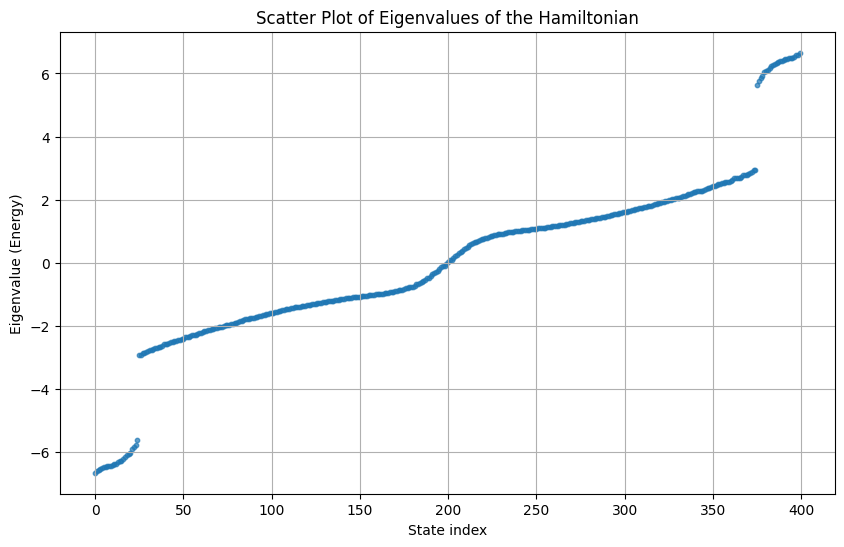

In [ ]:
# Compute eigenvalues
eigenvalues = np.linalg.eigvalsh(H)

# Sort eigenvalues (optional)
eigenvalues = np.sort(eigenvalues)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(eigenvalues)), eigenvalues, s=10, alpha=0.7)
plt.xlabel("State index")
plt.ylabel("Eigenvalue (Energy)")
plt.title("Scatter Plot of Eigenvalues of the Hamiltonian")
plt.grid(True)
plt.show()


In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Define writer
writer = FFMpegWriter(fps=30, metadata=dict(artist='Bashar Karaja'), bitrate=1800)

# Save the animation as an MP4 file
ani.save("Cout=1_nonlinear_g_A=g,g_B=0.1g_intesity=3_g=10_long.mp4", writer=writer)
print("Saved Successfully")

Saved Successfully


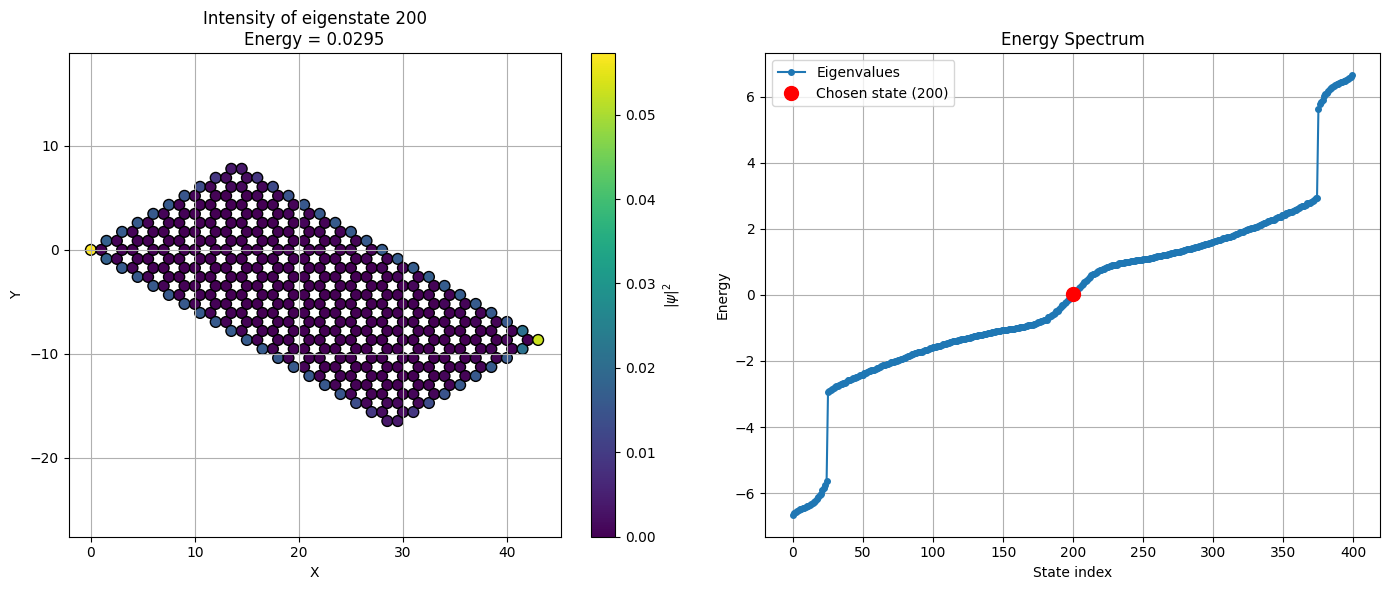

In [ ]:
# Step 2: Diagonalize Hamiltonian
eigenvalues, eigenvectors = np.linalg.eigh(H)

# Step 3: Generate real space coordinates
X, Y = generate_zigzag_coords(n, m)

# Step 4: Choose an eigenvector to plot
index_to_plot = 200  # middle eigenstate (can change)
psi = eigenvectors[:, index_to_plot]

# Step 5: Prepare intensity data
intensity = np.abs(psi)**2

# Step 6: Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# (a) Plot 1: Real space intensity map
sc = axs[0].scatter(X, Y, c=intensity, cmap='viridis', s=60, edgecolors='k')
plt.colorbar(sc, ax=axs[0], label=r'$|\psi|^2$')
axs[0].set_title(f'Intensity of eigenstate {index_to_plot}\nEnergy = {eigenvalues[index_to_plot]:.4f}')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].axis('equal')
axs[0].grid(True)

# (b) Plot 2: Energy spectrum
axs[1].plot(np.arange(len(eigenvalues)), eigenvalues, 'o-', markersize=4, label='Eigenvalues')
axs[1].plot(index_to_plot, eigenvalues[index_to_plot], 'ro', markersize=10, label=f'Chosen state ({index_to_plot})')
axs[1].set_xlabel('State index')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy Spectrum')
axs[1].legend()
axs[1].grid(True)

# # (c) Plot 3: Phase map of eigenstate
# phase = np.angle(eigenvectors[:, index_to_plot])
# sc_phase = axs[2].scatter(X, Y, c=phase, cmap='twilight', s=50, edgecolors='k')
# plt.colorbar(sc_phase, ax=axs[2], label=r'$\arg(\psi)$')
# axs[2].set_title(f'Phase of eigenstate {index_to_plot}\nEnergy = {eigenvalues[index_to_plot]:.4f}')
# axs[2].set_xlabel('X')
# axs[2].set_ylabel('Y')
# axs[2].axis('equal')
# axs[2].grid(True)

plt.tight_layout()
plt.show()


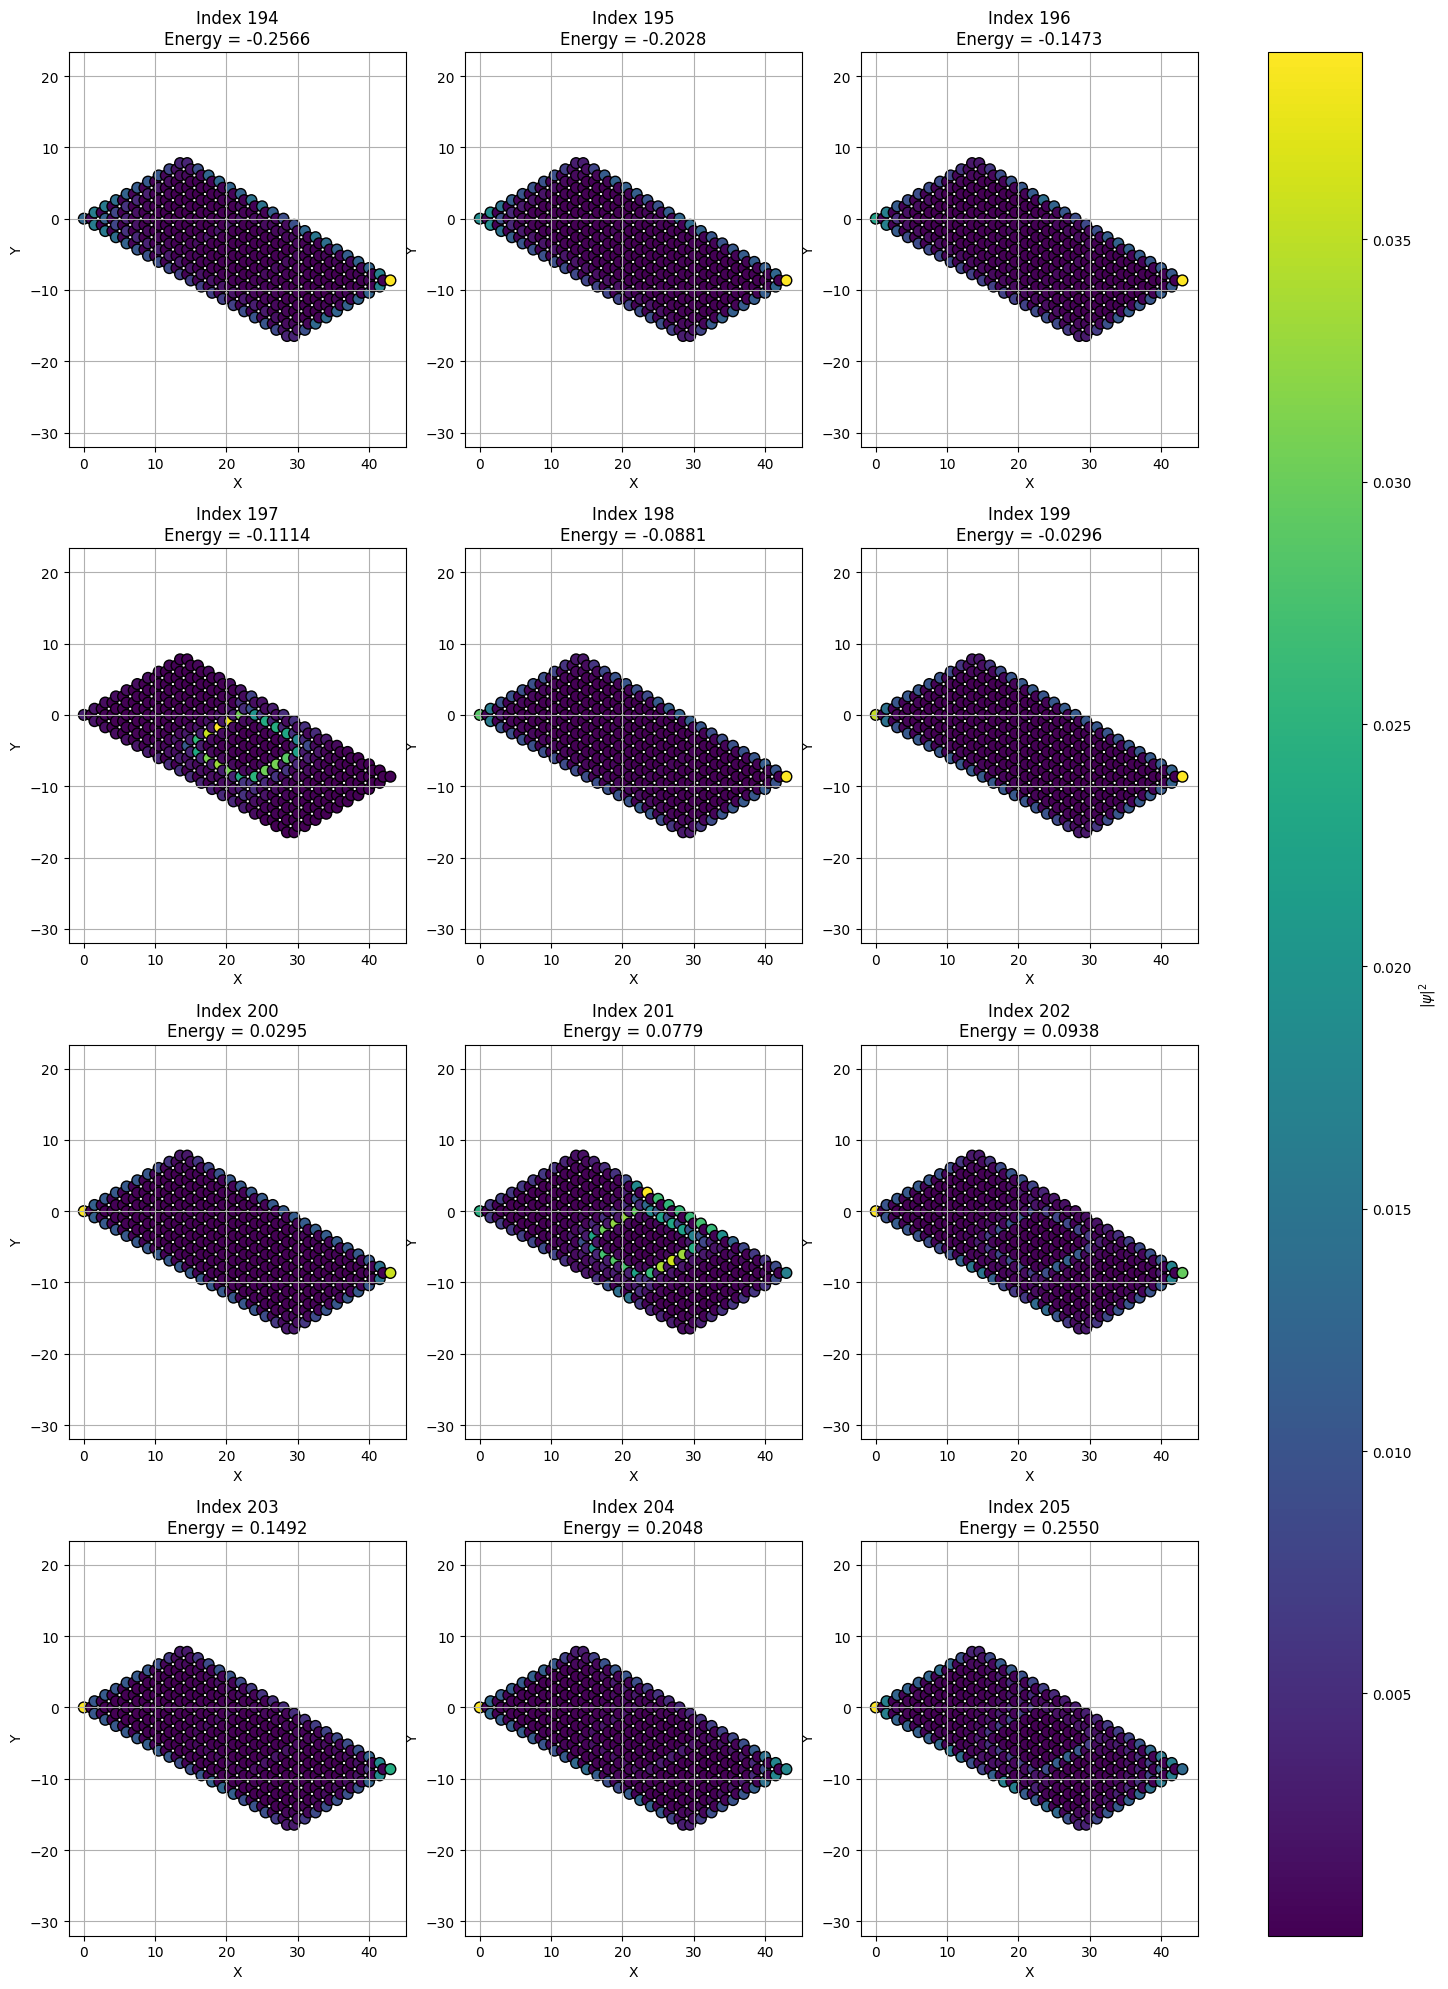

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Generate real space coordinates
X, Y = generate_zigzag_coords(n, m)

# Define how many eigenstates to plot (must be even)
num_states_to_plot = 12  # e.g., 10 means 5 below and 5 above the center

# Step 4: Calculate center and indices
center_index = len(eigenvalues) // 2
half = num_states_to_plot // 2
indices_to_plot = list(range(center_index - half, center_index + half))

# Step 5: Plotting
n_cols = 3
n_rows = int(np.ceil(len(indices_to_plot) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

for i, idx in enumerate(indices_to_plot):
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col] if n_rows > 1 else axs[col]

    psi = eigenvectors[:, idx]
    intensity = np.abs(psi)**2

    sc = ax.scatter(X, Y, c=intensity, cmap='viridis', s=60, edgecolors='k')
    ax.set_title(f'Index {idx}\nEnergy = {eigenvalues[idx]:.4f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('equal')
    ax.grid(True)

# Remove empty subplots if needed
for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axs[row, col] if n_rows > 1 else axs[col])

plt.tight_layout()
fig.colorbar(sc, ax=axs.ravel().tolist(), label=r'$|\psi|^2$')
plt.show()


# Save Animation

In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Define writer
writer = FFMpegWriter(fps=30, metadata=dict(artist='Bashar Karaja'), bitrate=1800)

# Save the animation as an MP4 file
ani.save("Cout=1_nonlinear_g_A=5_g_B=0.5.mp4", writer=writer)
print("Saved Successfully")

Saved Successfully


# site intensity tracking

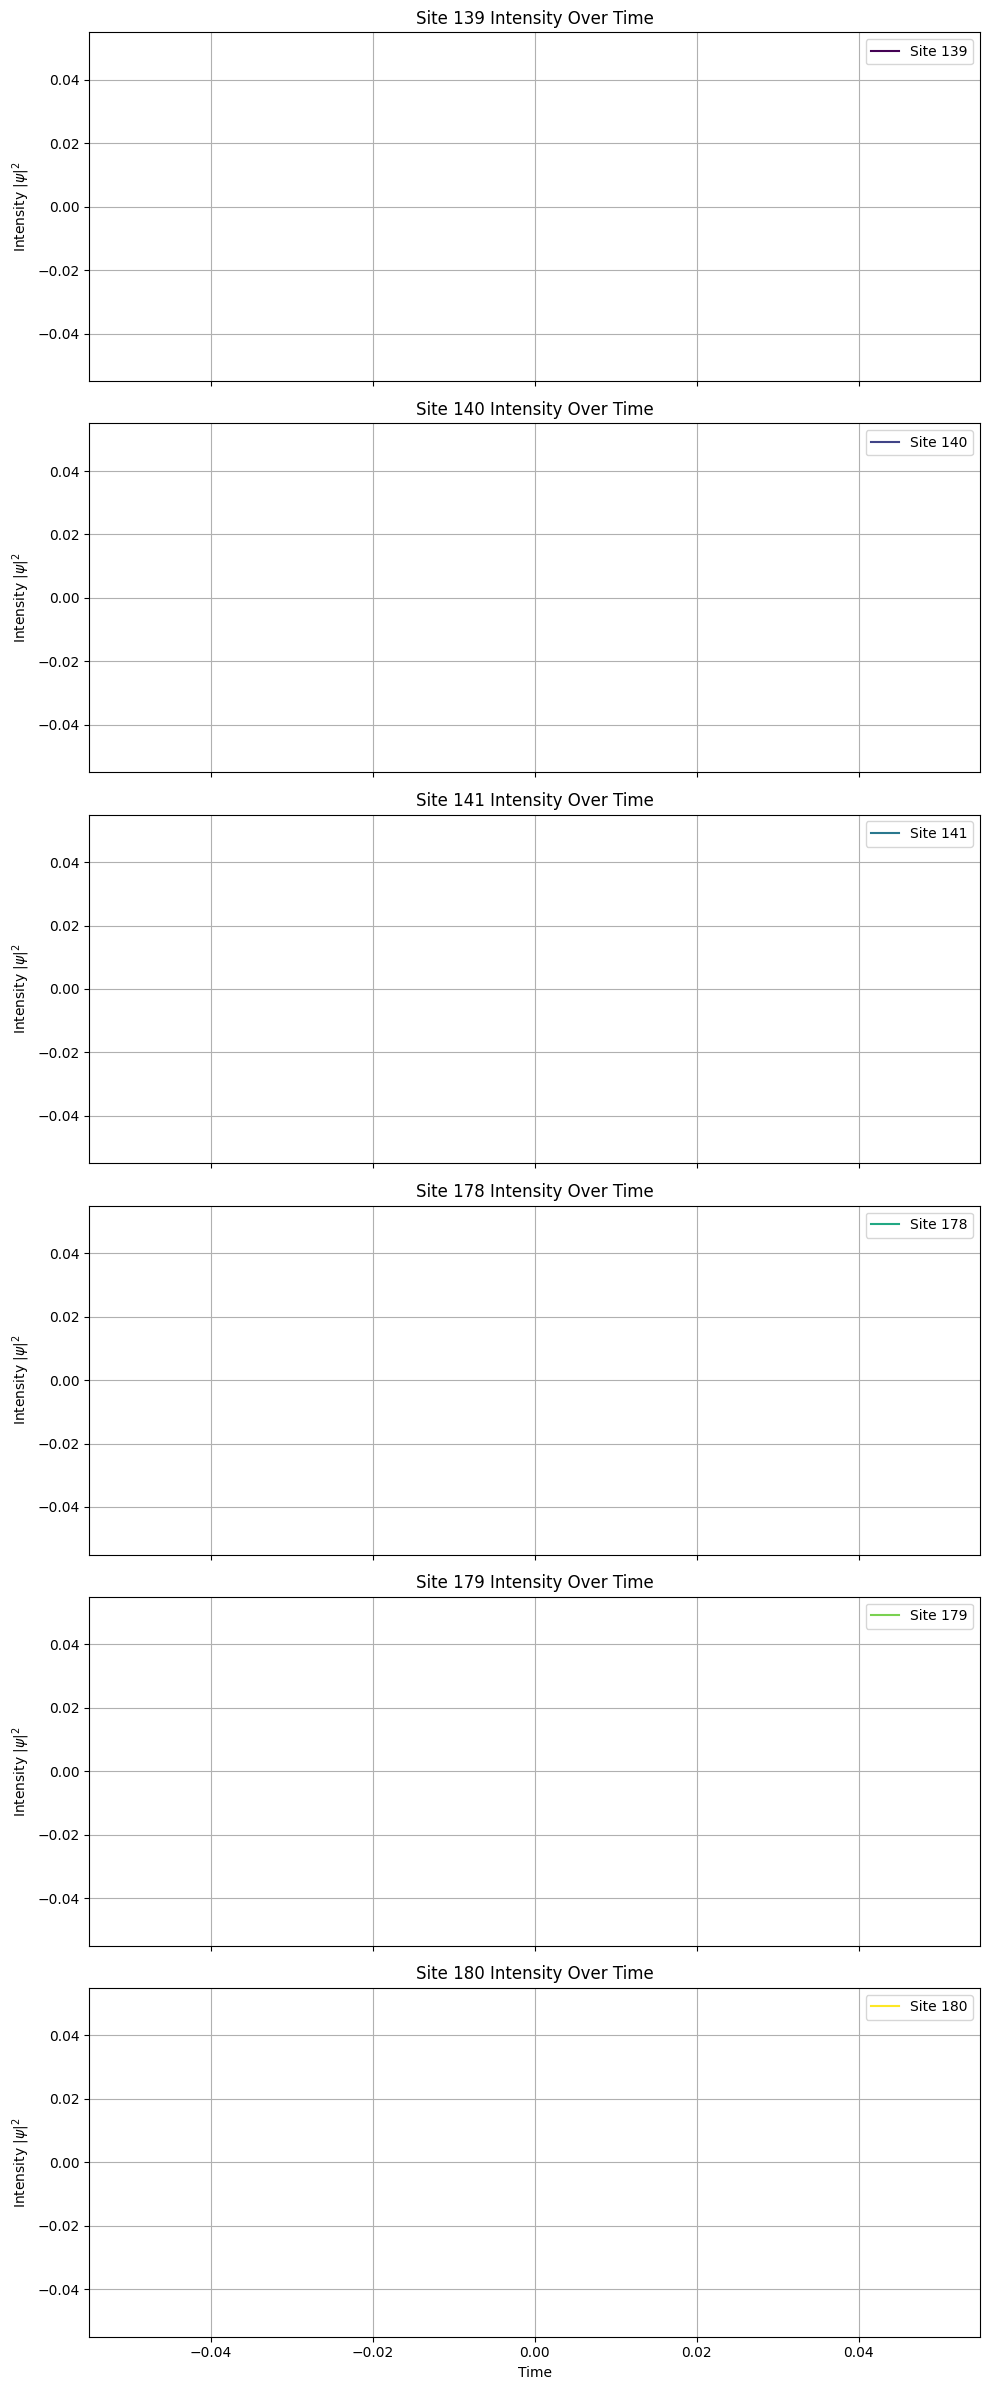

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

times = np.arange(timesteps) * dt  # actual time values
selected_sites = nonlinear_sites[0:6]  # or e.g., nonlinear_sites[2:6]

fig, axes = plt.subplots(len(selected_sites), 1, figsize=(10, 4 * len(selected_sites)), sharex=True)

# Pick distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_sites)))

if len(selected_sites) == 1:
    axes = [axes]  # Make sure it's iterable

for ax, site, color in zip(axes, selected_sites, colors):
    ax.plot(times * 100, site_intensities[site], color=color, label=f"Site {site}")
    ax.set_title(f"Site {site} Intensity Over Time")
    ax.set_ylabel("Intensity $|\psi|^2$")
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel("Time")

plt.tight_layout()
plt.show()


# adding Defect

In [ ]:
import numpy as np

def haldane_zigzag_defect(n, m, c, cNN_mag, phi, M1, M2, chunk, g, psi=None, nonlinear_sites=None, defect_dict=None):
    """
    Generate the Haldane tight-binding Hamiltonian on a zigzag nanoribbon,
    with optional Kerr nonlinearity and multiple site-specific defect masses.

    Parameters:
        n, m            : Number of unit cells in x and y directions
        c               : Nearest-neighbor hopping strength
        cNN_mag, phi    : Magnitude and phase of next-nearest-neighbor hopping
        M1              : Mass term outside the central chunk
        M2              : Mass term inside the central chunk
        chunk           : Half-width of the square central region (chunk)
        g               : Kerr nonlinearity strength (set to 0 to disable)
        psi             : Wavefunction to compute nonlinearity from
        nonlinear_sites : Not used here, can be integrated if needed
        defect_dict     : Dictionary {(ix, iy, s): M_defect_value} for defect mass terms
    """
    N = 2 * n * m
    H = np.zeros((N, N), dtype=complex)
    cNN = cNN_mag * np.exp(1j * phi)

    def index(ix, iy, s):
        """Map (ix, iy, sublattice) to global site index"""
        return 2 * (iy * n + ix) + s

    for ix in range(n):
        for iy in range(m):
            a = index(ix, iy, 0)  # A sublattice
            b = index(ix, iy, 1)  # B sublattice

            # Default mass terms (M1)
            H[a, a] = M1 / 2
            H[b, b] = -M1 / 2

            # Apply defect mass if site is in defect_dict
            if defect_dict is not None:
                if (ix, iy, 0) in defect_dict:
                    H[a, a] = defect_dict[(ix, iy, 0)] / 2
                if (ix, iy, 1) in defect_dict:
                    H[b, b] = -defect_dict[(ix, iy, 1)] / 2

            # Apply chunk modification (if not already overridden by a defect)
            elif (n//2 - chunk <= ix <= n//2 + chunk) and (m//2 - chunk <= iy <= m//2 + chunk):
                if g != 0 and psi is not None:
                    H[a, a] = g * np.abs(psi[a])**2
                    H[b, b] = -g * np.abs(psi[b])**2
                elif g == 0:
                    H[a, a] = M2 / 2
                    H[b, b] = -M2 / 2

            # Nearest-neighbor hopping (A-B)
            if ix + 1 < n:
                a1 = index(ix + 1, iy, 0)
                H[b, a1] = -c
            if iy + 1 < m:
                a2 = index(ix, iy + 1, 0)
                H[b, a2] = -c
            H[a, b] = -c

            # Next-nearest-neighbor hopping (A-A and B-B)
            a_nn_offsets = [(1, 0), (-1, 1), (0, -1)]
            for dx, dy in a_nn_offsets:
                ni, nj = ix + dx, iy + dy
                if 0 <= ni < n and 0 <= nj < m:
                    a2 = index(ni, nj, 0)
                    H[a, a2] = -cNN

            b_nn_offsets = [(-1, 0), (1, -1), (0, 1)]
            for dx, dy in b_nn_offsets:
                ni, nj = ix + dx, iy + dy
                if 0 <= ni < n and 0 <= nj < m:
                    b2 = index(ni, nj, 1)
                    H[b, b2] = -cNN

    # Hermitian symmetrization
    H = H + H.conj().T
    return H


In [ ]:
# Pick sublattice 0 (A sites)
defect_dict = {
    (16, 10, 0): 0.1,
    (16, 11, 0): 0.1,
    (16, 12, 0): 0.1
}


H_defect = haldane_zigzag_defect(
    n=20, m=20, c=1.0, cNN_mag=0.1, phi=np.pi/2,
    M1=6.0, M2=0.1, chunk=6, g=0.0,
    defect_dict=defect_dict
)



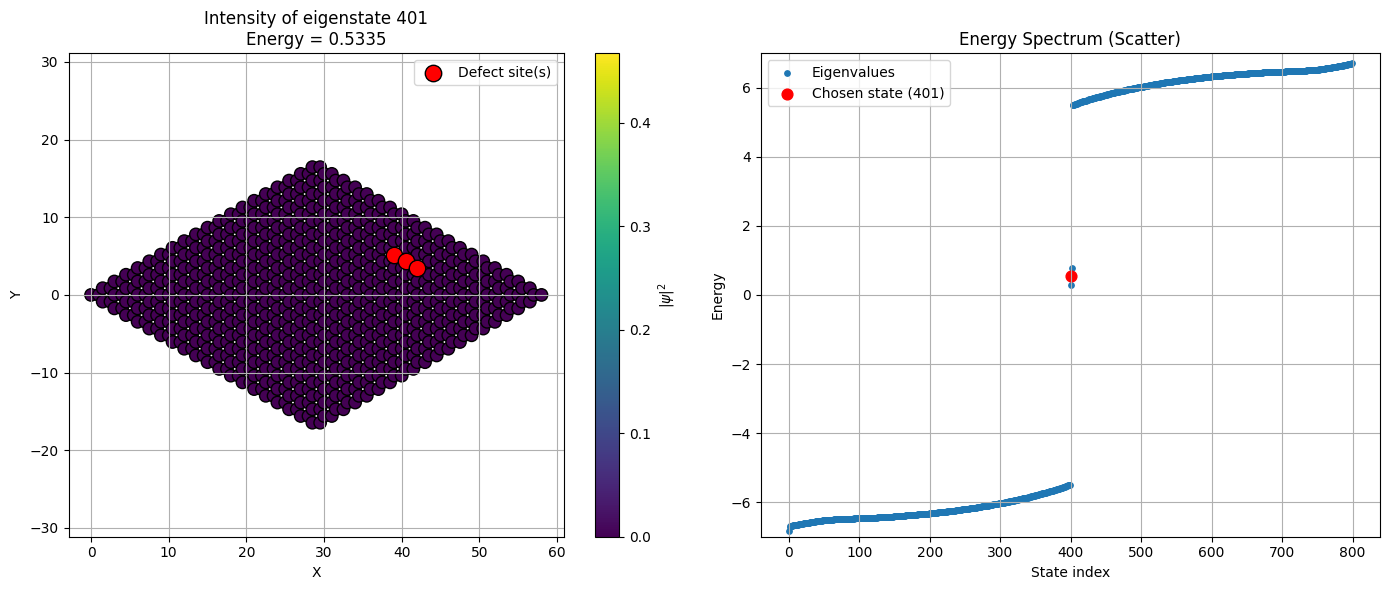

In [ ]:
# Step 1: Diagonalize Hamiltonian
eigenvalues, eigenvectors = np.linalg.eigh(H_defect)

# Step 2: Generate real-space coordinates
X, Y = generate_zigzag_coords(n, m)

# Step 3: Choose eigenstate to plot
index_to_plot = 401
psi = eigenvectors[:, index_to_plot]
intensity = np.abs(psi)**2

# Step 4: Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Real-space intensity map ---
sc = axs[0].scatter(X, Y, c=intensity, cmap='viridis', s=80, edgecolors='k')
plt.colorbar(sc, ax=axs[0], label=r'$|\psi|^2$')
axs[0].set_title(f'Intensity of eigenstate {index_to_plot}\nEnergy = {eigenvalues[index_to_plot]:.4f}')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].axis('equal')
axs[0].grid(True)

# Optional: highlight defect sites in red
defect_indices = [2 * (iy * n + ix) + s for (ix, iy, s) in defect_dict]
axs[0].scatter(X[defect_indices], Y[defect_indices],
               color='red', s=140, edgecolors='black',
               marker='o', label='Defect site(s)', zorder=3)
axs[0].legend()

# --- Plot 2: Energy spectrum ---
axs[1].scatter(np.arange(len(eigenvalues)), eigenvalues, s=15, label='Eigenvalues')
axs[1].scatter(index_to_plot, eigenvalues[index_to_plot], c='red', s=60, label=f'Chosen state ({index_to_plot})')
axs[1].set_xlabel('State index')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy Spectrum (Scatter)')
axs[1].legend()
axs[1].grid(True)
plt.ylim([-7, 7])

plt.tight_layout()
plt.show()
